# Hypothesis Testing: A/B Testing for Football Player Market Value

This notebook performs statistical hypothesis testing to analyze the relationship between various player features and market value changes (delta price).

## Tests Performed:
1. **Nationality vs Delta Price** - ANOVA / Kruskal-Wallis
2. **Team ID vs Delta Price** - ANOVA / Kruskal-Wallis  
3. **Age vs Delta Price** - Correlation / Regression
4. **Goals + Assists Sum vs Delta Price** - Correlation / Regression
5. **Contract Until vs Delta Price** - Correlation / Regression
6. **Key Passes vs Delta Price** - Correlation / Regression

## Statistical Methods:
- **T-test / Mann-Whitney U**: For comparing two groups
- **ANOVA / Kruskal-Wallis**: For comparing multiple groups
- **Pearson/Spearman Correlation**: For continuous variables
- **Effect Size**: Cohen's d, Eta-squared for practical significance

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import (
    ttest_ind, mannwhitneyu, f_oneway, kruskal,
    pearsonr, spearmanr, shapiro, levene, normaltest
)
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [10]:
df = pd.read_csv('../data/cleaned_player_data.csv')

df['delta_price'] = df['MarketValueCurrent'] - df['MarketValuePrevious']
df['delta_price_pct'] = ((df['MarketValueCurrent'] - df['MarketValuePrevious']) / 
                          df['MarketValuePrevious'].replace(0, np.nan)) * 100


df['delta_price_log'] = np.sign(df['delta_price']) * np.log10(np.abs(df['delta_price']) + 1)

df['contractUntil'] = pd.to_datetime(df['contractUntil'], format='mixed')
df['contract_years_remaining'] = (df['contractUntil'] - pd.Timestamp('2025-01-06')).dt.days / 365.25

NATIONALITY_MAP = {
    9: 'Argentina', 26: 'Brazil', 189: 'USA', 157: 'Spain', 184: 'Turkey',
    50: 'France', 40: 'Germany', 135: 'Poland', 19: 'Belgium', 39: 'Denmark',
    122: 'Nigeria', 37: 'Croatia', 136: 'Portugal', 75: 'Italy', 179: 'Uruguay',
    80: 'Japan', 48: 'England', 108: 'Mexico', 117: 'Netherlands', 33: 'Colombia',
    153: 'Serbia', 6: 'Algeria', 156: 'South Korea', 152: 'Senegal', 16: 'Austria',
    171: 'Switzerland', 90: 'Côte d\'Ivoire', 54: 'Ghana', 103: 'Mali', 27: 'Cameroon'
}

df['nationality_name'] = df['nationalityId'].map(NATIONALITY_MAP).fillna(df['nationalityId'].astype(str))

print(f"Dataset shape: {df.shape}")
print(f"\nDelta Price Statistics:")
print(df['delta_price'].describe())
print(f"\nLog-transformed Delta Price Statistics:")
print(df['delta_price_log'].describe())
print(f"\nMissing values in key columns:")
print(df[['delta_price', 'nationalityId', 'teamId', 'age', 'goalsAssistsSum', 
          'contract_years_remaining', 'keyPasses']].isnull().sum())

Dataset shape: (5466, 137)

Delta Price Statistics:
count    5.466000e+03
mean     1.203622e+04
std      2.362027e+06
min     -2.000000e+07
25%     -2.500000e+05
50%      0.000000e+00
75%      0.000000e+00
max      3.000000e+07
Name: delta_price, dtype: float64

Log-transformed Delta Price Statistics:
count    5466.000000
mean       -0.899847
std         4.562312
min        -7.301030
25%        -5.397942
50%         0.000000
75%         0.000000
max         7.477121
Name: delta_price_log, dtype: float64

Missing values in key columns:
delta_price                 0
nationalityId               0
teamId                      0
age                         0
goalsAssistsSum             0
contract_years_remaining    0
keyPasses                   0
dtype: int64


In [11]:

def cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (group1.mean() - group2.mean()) / pooled_std

def eta_squared(groups, values):
    """Calculate Eta-squared for ANOVA effect size"""
    grand_mean = values.mean()
    ss_between = sum(len(g) * (g.mean() - grand_mean)**2 for g in groups)
    ss_total = sum((values - grand_mean)**2)
    return ss_between / ss_total

def interpret_p_value(p):
    """Interpret p-value significance"""
    if p < 0.001:
        return "*** (p < 0.001) - Highly Significant"
    elif p < 0.01:
        return "** (p < 0.01) - Very Significant"
    elif p < 0.05:
        return "* (p < 0.05) - Significant"
    else:
        return "ns (p >= 0.05) - Not Significant"

def interpret_effect_size(d):
    """Interpret Cohen's d effect size"""
    d = abs(d)
    if d < 0.2:
        return "Negligible"
    elif d < 0.5:
        return "Small"
    elif d < 0.8:
        return "Medium"
    else:
        return "Large"

def check_normality(data, name="data"):
    """Check normality using multiple tests"""
    if len(data) > 5000:
        stat, p = normaltest(data.dropna())
        test_name = "D'Agostino-Pearson"
    else:
        stat, p = shapiro(data.dropna()[:5000])
        test_name = "Shapiro-Wilk"
    return test_name, stat, p

print("Helper functions defined!")

Helper functions defined!


## 1. Nationality vs Delta Price

**Hypothesis:**
- H₀: There is no significant difference in delta price across different nationalities
- H₁: There is a significant difference in delta price across different nationalities

**Test:** Kruskal-Wallis (non-parametric alternative to ANOVA) since delta price is not normally distributed

In [12]:

nationality_counts = df['nationalityId'].value_counts()
top_nationalities = nationality_counts.head(15).index.tolist()
df_top_nat = df[df['nationalityId'].isin(top_nationalities)].copy()

df_top_nat['country'] = df_top_nat['nationalityId'].map(NATIONALITY_MAP).fillna('Unknown')

print(f"Analyzing top 15 nationalities (n={len(df_top_nat)} players)")
print(f"Countries included: {df_top_nat['country'].unique().tolist()}")

nationality_groups = [df_top_nat[df_top_nat['nationalityId'] == nat]['delta_price'].values 
                      for nat in top_nationalities]

stat_kw, p_kw = kruskal(*nationality_groups)

eta_sq = stat_kw / (len(df_top_nat) - 1)

print(f"\n{'='*60}")
print("KRUSKAL-WALLIS TEST: Nationality vs Delta Price")
print(f"{'='*60}")
print(f"H-statistic: {stat_kw:.4f}")
print(f"P-value: {p_kw:.6f}")
print(f"Significance: {interpret_p_value(p_kw)}")
print(f"Effect size (η²): {eta_sq:.6f}")

print(f"\n{'='*60}")
print("SUMMARY STATISTICS BY NATIONALITY")
print(f"{'='*60}")
nat_stats = df_top_nat.groupby(['nationalityId', 'country'])['delta_price'].agg(['count', 'mean', 'median', 'std'])
nat_stats = nat_stats.sort_values('mean', ascending=False)
print(nat_stats.head(15).to_string())

Analyzing top 15 nationalities (n=3786 players)
Countries included: ['Spain', 'Germany', 'Poland', 'Uruguay', 'Denmark', 'France', 'Nigeria', 'Brazil', 'USA', 'Belgium', 'Argentina', 'Portugal', 'Italy', 'Turkey', 'Croatia']

KRUSKAL-WALLIS TEST: Nationality vs Delta Price
H-statistic: 46.8334
P-value: 0.000020
Significance: *** (p < 0.001) - Highly Significant
Effect size (η²): 0.012373

SUMMARY STATISTICS BY NATIONALITY
                         count           mean  median           std
nationalityId country                                              
50            France       265  458679.245283     0.0  3.362680e+06
136           Portugal     168  412053.571429     0.0  3.181306e+06
40            Germany      216  209375.000000     0.0  2.872568e+06
39            Denmark      191   93324.607330     0.0  1.742512e+06
184           Turkey       304   54851.973684     0.0  8.059616e+05
122           Nigeria      186   26344.086022     0.0  2.234541e+06
135           Poland       197

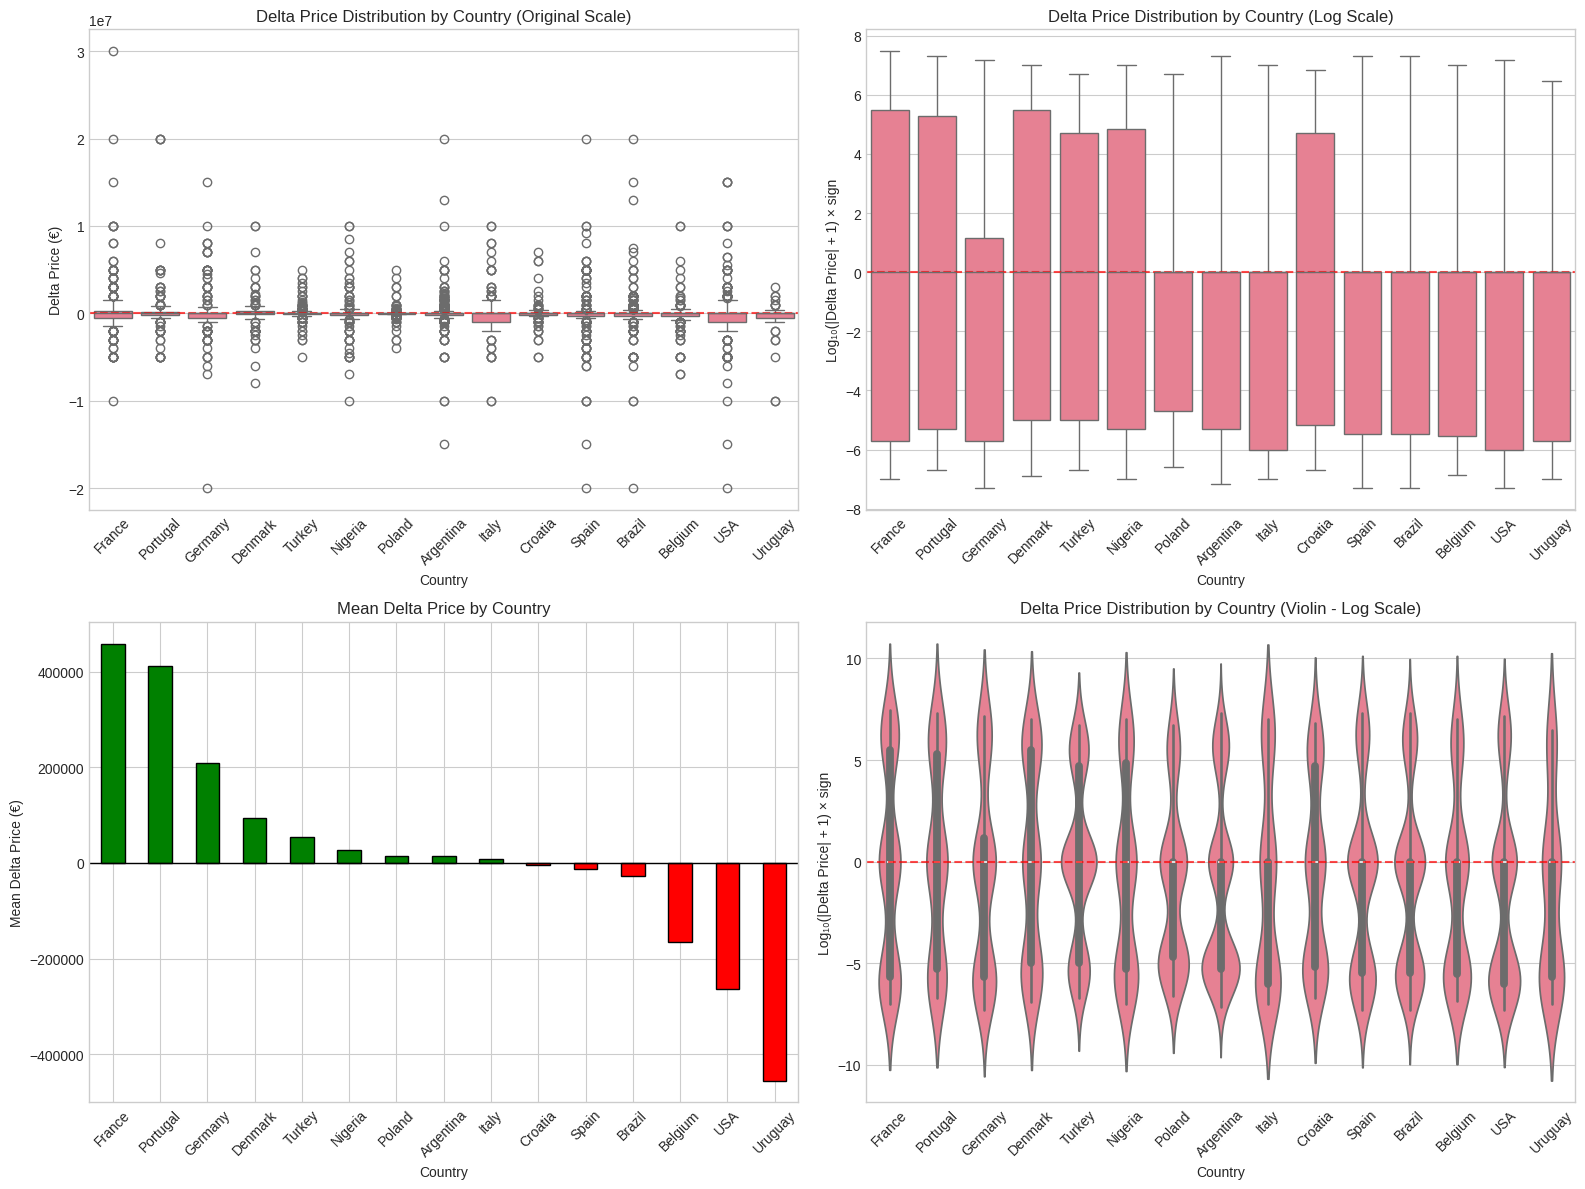

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

country_order = df_top_nat.groupby('country')['delta_price'].mean().sort_values(ascending=False).index.tolist()

sns.boxplot(data=df_top_nat, x='country', y='delta_price', order=country_order, ax=axes[0, 0])
axes[0, 0].set_title('Delta Price Distribution by Country (Original Scale)', fontsize=12)
axes[0, 0].set_xlabel('Country')
axes[0, 0].set_ylabel('Delta Price (€)')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7)

sns.boxplot(data=df_top_nat, x='country', y='delta_price_log', order=country_order, ax=axes[0, 1])
axes[0, 1].set_title('Delta Price Distribution by Country (Log Scale)', fontsize=12)
axes[0, 1].set_xlabel('Country')
axes[0, 1].set_ylabel('Log₁₀(|Delta Price| + 1) × sign')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.7)

nat_means = df_top_nat.groupby('country')['delta_price'].mean().sort_values(ascending=False)
colors = ['green' if x > 0 else 'red' for x in nat_means.values]
nat_means.plot(kind='bar', ax=axes[1, 0], color=colors, edgecolor='black')
axes[1, 0].set_title('Mean Delta Price by Country', fontsize=12)
axes[1, 0].set_xlabel('Country')
axes[1, 0].set_ylabel('Mean Delta Price (€)')
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1, 0].tick_params(axis='x', rotation=45)

sns.violinplot(data=df_top_nat, x='country', y='delta_price_log', order=country_order, ax=axes[1, 1])
axes[1, 1].set_title('Delta Price Distribution by Country (Violin - Log Scale)', fontsize=12)
axes[1, 1].set_xlabel('Country')
axes[1, 1].set_ylabel('Log₁₀(|Delta Price| + 1) × sign')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## 2. Team ID vs Delta Price

**Hypothesis:**
- H₀: There is no significant difference in delta price across different teams
- H₁: There is a significant difference in delta price across different teams

**Test:** Kruskal-Wallis (non-parametric) for multi-group comparison

In [14]:

team_counts = df['teamId'].value_counts()
top_teams = team_counts.head(20).index.tolist()
df_top_teams = df[df['teamId'].isin(top_teams)]

print(f"Analyzing top 20 teams (n={len(df_top_teams)} players)")

team_groups = [df_top_teams[df_top_teams['teamId'] == team]['delta_price'].values 
               for team in top_teams]

stat_kw, p_kw = kruskal(*team_groups)

eta_sq = stat_kw / (len(df_top_teams) - 1)

print(f"\n{'='*60}")
print("KRUSKAL-WALLIS TEST: Team vs Delta Price")
print(f"{'='*60}")
print(f"H-statistic: {stat_kw:.4f}")
print(f"P-value: {p_kw:.6f}")
print(f"Significance: {interpret_p_value(p_kw)}")
print(f"Effect size (η²): {eta_sq:.6f}")

print(f"\n{'='*60}")
print("SUMMARY STATISTICS BY TEAM (Top 20)")
print(f"{'='*60}")
team_stats = df_top_teams.groupby(['teamId', 'teamName'])['delta_price'].agg(['count', 'mean', 'median', 'std'])
team_stats = team_stats.sort_values('mean', ascending=False)
print(team_stats.head(20).to_string())

Analyzing top 20 teams (n=543 players)

KRUSKAL-WALLIS TEST: Team vs Delta Price
H-statistic: 47.7504
P-value: 0.000279
Significance: *** (p < 0.001) - Highly Significant
Effect size (η²): 0.088100

SUMMARY STATISTICS BY TEAM (Top 20)
                                   count          mean     median           std
teamId teamName                                                                
1047   Como 1907 ~ 1047               27  2.340741e+06   500000.0  5.596377e+06
16     Borussia Dortmund ~ 16         26  2.315385e+06        0.0  4.204540e+06
631    Chelsea FC ~ 631               30  9.666667e+05        0.0  6.805086e+06
289    Sunderland AFC ~ 289           30  8.750000e+05        0.0  2.507394e+06
58     RSC Anderlecht ~ 58            26  4.134615e+05        0.0  2.147536e+06
12     AS Roma ~ 12                   26  3.000000e+05  -100000.0  4.446122e+06
1132   Burnley FC ~ 1132              29  2.620690e+05        0.0  1.489047e+06
114977 San Diego FC ~ 114977          29  1.9

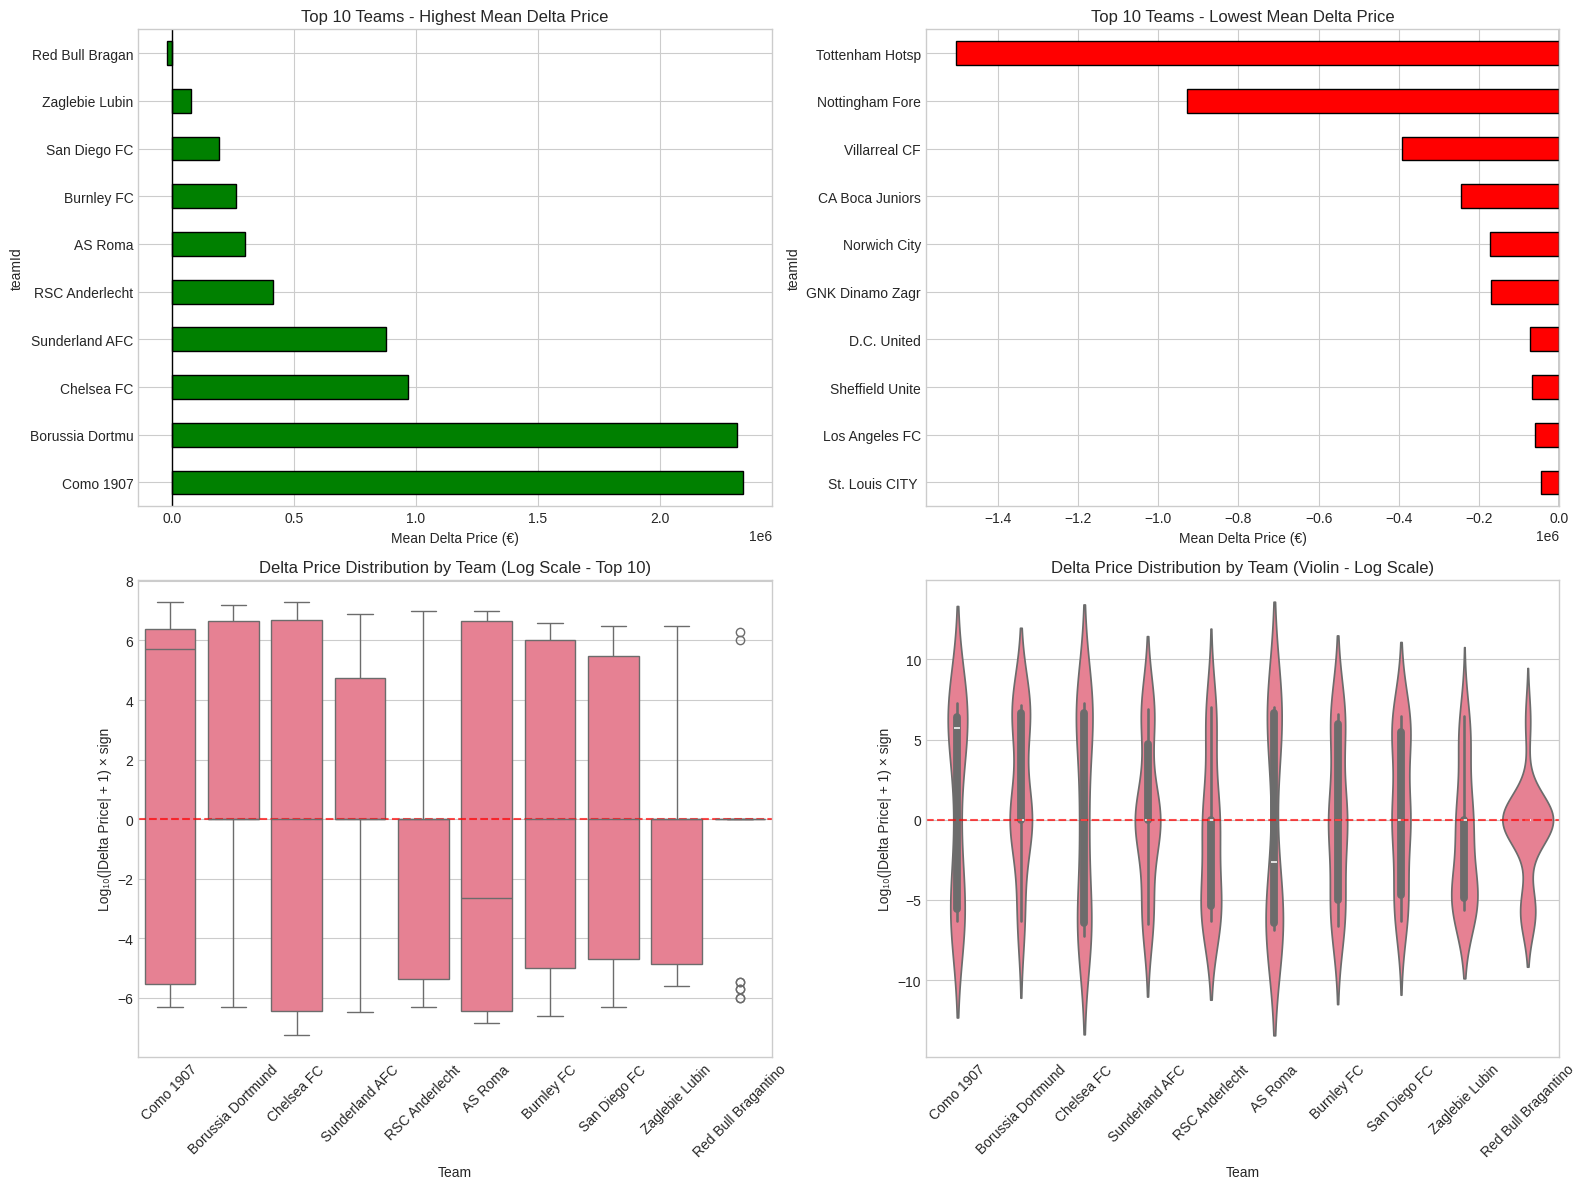

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

team_name_map = df.set_index('teamId')['teamName'].str.split(' ~ ').str[0].to_dict()
df_top_teams['team_name'] = df_top_teams['teamId'].map(team_name_map)

team_means = df_top_teams.groupby('teamId')['delta_price'].mean().sort_values(ascending=False)
top_10_positive = team_means.head(10)
top_10_negative = team_means.tail(10)

colors_pos = ['green'] * len(top_10_positive)
ax1_labels = [team_name_map.get(t, str(t))[:15] for t in top_10_positive.index]
top_10_positive.plot(kind='barh', ax=axes[0, 0], color=colors_pos, edgecolor='black')
axes[0, 0].set_yticklabels(ax1_labels)
axes[0, 0].set_title('Top 10 Teams - Highest Mean Delta Price', fontsize=12)
axes[0, 0].set_xlabel('Mean Delta Price (€)')
axes[0, 0].axvline(x=0, color='black', linestyle='-', linewidth=1)

colors_neg = ['red'] * len(top_10_negative)
ax2_labels = [team_name_map.get(t, str(t))[:15] for t in top_10_negative.index]
top_10_negative.plot(kind='barh', ax=axes[0, 1], color=colors_neg, edgecolor='black')
axes[0, 1].set_yticklabels(ax2_labels)
axes[0, 1].set_title('Top 10 Teams - Lowest Mean Delta Price', fontsize=12)
axes[0, 1].set_xlabel('Mean Delta Price (€)')
axes[0, 1].axvline(x=0, color='black', linestyle='-', linewidth=1)

team_order = df_top_teams.groupby('team_name')['delta_price'].mean().sort_values(ascending=False).head(10).index.tolist()
df_top_10_teams = df_top_teams[df_top_teams['team_name'].isin(team_order)]
sns.boxplot(data=df_top_10_teams, x='team_name', y='delta_price_log', order=team_order, ax=axes[1, 0])
axes[1, 0].set_title('Delta Price Distribution by Team (Log Scale - Top 10)', fontsize=12)
axes[1, 0].set_xlabel('Team')
axes[1, 0].set_ylabel('Log₁₀(|Delta Price| + 1) × sign')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7)

sns.violinplot(data=df_top_10_teams, x='team_name', y='delta_price_log', order=team_order, ax=axes[1, 1])
axes[1, 1].set_title('Delta Price Distribution by Team (Violin - Log Scale)', fontsize=12)
axes[1, 1].set_xlabel('Team')
axes[1, 1].set_ylabel('Log₁₀(|Delta Price| + 1) × sign')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## 3. Age vs Delta Price

**Hypothesis:**
- H₀: There is no significant correlation between age and delta price
- H₁: There is a significant correlation between age and delta price

**Tests:** 
- Pearson correlation (linear relationship)
- Spearman correlation (monotonic relationship)
- A/B Test: Young players (≤25) vs Older players (>25)

In [16]:

df_age = df[df['age'].notna()].copy()

pearson_r, pearson_p = pearsonr(df_age['age'], df_age['delta_price'])
spearman_r, spearman_p = spearmanr(df_age['age'], df_age['delta_price'])

print(f"{'='*60}")
print("CORRELATION TESTS: Age vs Delta Price")
print(f"{'='*60}")
print(f"\n Pearson Correlation:")
print(f"   r = {pearson_r:.4f}")
print(f"   p-value = {pearson_p:.6f}")
print(f"   Significance: {interpret_p_value(pearson_p)}")

print(f"\n Spearman Correlation:")
print(f"   ρ = {spearman_r:.4f}")
print(f"   p-value = {spearman_p:.6f}")
print(f"   Significance: {interpret_p_value(spearman_p)}")

df_age['age_group'] = df_age['age'].apply(lambda x: 'Young (≤25)' if x <= 25 else 'Older (>25)')
young = df_age[df_age['age_group'] == 'Young (≤25)']['delta_price']
older = df_age[df_age['age_group'] == 'Older (>25)']['delta_price']

stat_mw, p_mw = mannwhitneyu(young, older, alternative='two-sided')
effect_d = cohens_d(young, older)

print(f"\n{'='*60}")
print("A/B TEST: Young (≤25) vs Older (>25) Players")
print(f"{'='*60}")
print(f"Young players: n={len(young)}, mean=€{young.mean():,.0f}, median=€{young.median():,.0f}")
print(f"Older players: n={len(older)}, mean=€{older.mean():,.0f}, median=€{older.median():,.0f}")
print(f"\nMann-Whitney U Test:")
print(f"   U-statistic: {stat_mw:.0f}")
print(f"   p-value: {p_mw:.6f}")
print(f"   Significance: {interpret_p_value(p_mw)}")
print(f"   Cohen's d: {effect_d:.4f} ({interpret_effect_size(effect_d)})")

CORRELATION TESTS: Age vs Delta Price

 Pearson Correlation:
   r = -0.1648
   p-value = 0.000000
   Significance: *** (p < 0.001) - Highly Significant

 Spearman Correlation:
   ρ = -0.3326
   p-value = 0.000000
   Significance: *** (p < 0.001) - Highly Significant

A/B TEST: Young (≤25) vs Older (>25) Players
Young players: n=2648, mean=€396,380, median=€0
Older players: n=2818, mean=€-349,122, median=€-50,000

Mann-Whitney U Test:
   U-statistic: 4887095
   p-value: 0.000000
   Significance: *** (p < 0.001) - Highly Significant
   Cohen's d: 0.3196 (Small)


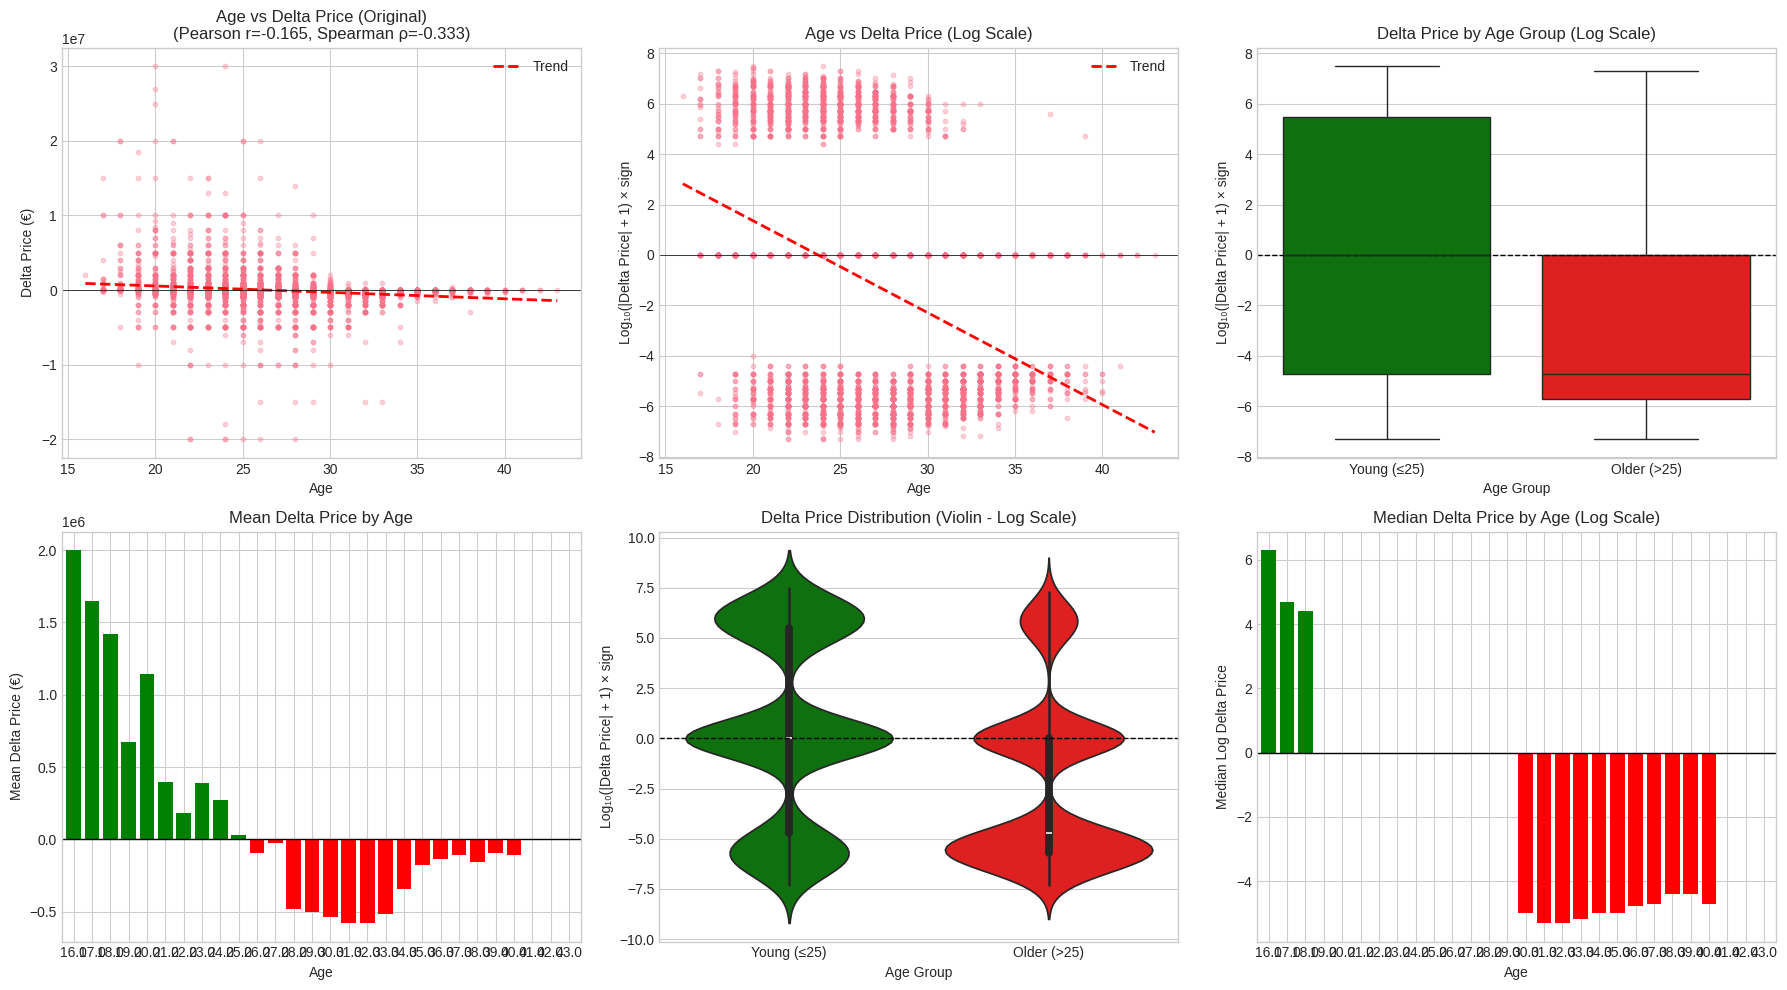

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

age_group_order = ['Young (≤25)', 'Older (>25)']

ax1 = axes[0, 0]
ax1.scatter(df_age['age'], df_age['delta_price'], alpha=0.3, s=10)
z = np.polyfit(df_age['age'], df_age['delta_price'], 1)
p = np.poly1d(z)
ax1.plot(df_age['age'].sort_values(), p(df_age['age'].sort_values()), "r--", linewidth=2, label='Trend')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax1.set_xlabel('Age')
ax1.set_ylabel('Delta Price (€)')
ax1.set_title(f'Age vs Delta Price (Original)\n(Pearson r={pearson_r:.3f}, Spearman ρ={spearman_r:.3f})')
ax1.legend()

ax2 = axes[0, 1]
ax2.scatter(df_age['age'], df_age['delta_price_log'], alpha=0.3, s=10)
z_log = np.polyfit(df_age['age'], df_age['delta_price_log'], 1)
p_log = np.poly1d(z_log)
ax2.plot(df_age['age'].sort_values(), p_log(df_age['age'].sort_values()), "r--", linewidth=2, label='Trend')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_xlabel('Age')
ax2.set_ylabel('Log₁₀(|Delta Price| + 1) × sign')
ax2.set_title('Age vs Delta Price (Log Scale)')
ax2.legend()

ax3 = axes[0, 2]
sns.boxplot(data=df_age, x='age_group', y='delta_price_log', order=age_group_order, ax=ax3, 
            palette=['green', 'red'])
ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax3.set_title('Delta Price by Age Group (Log Scale)')
ax3.set_xlabel('Age Group')
ax3.set_ylabel('Log₁₀(|Delta Price| + 1) × sign')

ax4 = axes[1, 0]
age_means = df_age.groupby('age')['delta_price'].mean()
colors = ['green' if x > 0 else 'red' for x in age_means.values]
age_means.plot(kind='bar', ax=ax4, color=colors, width=0.8)
ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax4.set_title('Mean Delta Price by Age')
ax4.set_xlabel('Age')
ax4.set_ylabel('Mean Delta Price (€)')
ax4.tick_params(axis='x', rotation=0)

ax5 = axes[1, 1]
sns.violinplot(data=df_age, x='age_group', y='delta_price_log', order=age_group_order, ax=ax5,
               palette=['green', 'red'])
ax5.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax5.set_title('Delta Price Distribution (Violin - Log Scale)')
ax5.set_xlabel('Age Group')
ax5.set_ylabel('Log₁₀(|Delta Price| + 1) × sign')

ax6 = axes[1, 2]
age_medians_log = df_age.groupby('age')['delta_price_log'].median()
colors_log = ['green' if x > 0 else 'red' for x in age_medians_log.values]
age_medians_log.plot(kind='bar', ax=ax6, color=colors_log, width=0.8)
ax6.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax6.set_title('Median Delta Price by Age (Log Scale)')
ax6.set_xlabel('Age')
ax6.set_ylabel('Median Log Delta Price')
ax6.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## 4. Goals + Assists Sum vs Delta Price

**Hypothesis:**
- H₀: There is no significant correlation between goals+assists and delta price
- H₁: There is a significant correlation between goals+assists and delta price

**Tests:** 
- Pearson & Spearman correlation
- A/B Test: High performers (above median) vs Low performers (below median)

In [18]:

df_ga = df[df['goalsAssistsSum'].notna()].copy()

pearson_r, pearson_p = pearsonr(df_ga['goalsAssistsSum'], df_ga['delta_price'])
spearman_r, spearman_p = spearmanr(df_ga['goalsAssistsSum'], df_ga['delta_price'])

print(f"{'='*60}")
print("CORRELATION TESTS: Goals+Assists vs Delta Price")
print(f"{'='*60}")
print(f"\n Pearson Correlation:")
print(f"   r = {pearson_r:.4f}")
print(f"   p-value = {pearson_p:.6f}")
print(f"   Significance: {interpret_p_value(pearson_p)}")

print(f"\n Spearman Correlation:")
print(f"   ρ = {spearman_r:.4f}")
print(f"   p-value = {spearman_p:.6f}")
print(f"   Significance: {interpret_p_value(spearman_p)}")

median_ga = df_ga['goalsAssistsSum'].median()
df_ga['performance_group'] = df_ga['goalsAssistsSum'].apply(
    lambda x: f'High (>{median_ga:.0f})' if x > median_ga else f'Low (≤{median_ga:.0f})')

high_perf = df_ga[df_ga['goalsAssistsSum'] > median_ga]['delta_price']
low_perf = df_ga[df_ga['goalsAssistsSum'] <= median_ga]['delta_price']

stat_mw, p_mw = mannwhitneyu(high_perf, low_perf, alternative='two-sided')
effect_d = cohens_d(high_perf, low_perf)

print(f"\n{'='*60}")
print(f"A/B TEST: High Performers (G+A>{median_ga:.0f}) vs Low Performers")
print(f"{'='*60}")
print(f"High performers: n={len(high_perf)}, mean=€{high_perf.mean():,.0f}, median=€{high_perf.median():,.0f}")
print(f"Low performers:  n={len(low_perf)}, mean=€{low_perf.mean():,.0f}, median=€{low_perf.median():,.0f}")
print(f"\nMann-Whitney U Test:")
print(f"   U-statistic: {stat_mw:.0f}")
print(f"   p-value: {p_mw:.6f}")
print(f"   Significance: {interpret_p_value(p_mw)}")
print(f"   Cohen's d: {effect_d:.4f} ({interpret_effect_size(effect_d)})")

CORRELATION TESTS: Goals+Assists vs Delta Price

 Pearson Correlation:
   r = -0.0180
   p-value = 0.183055
   Significance: ns (p >= 0.05) - Not Significant

 Spearman Correlation:
   ρ = -0.0092
   p-value = 0.496752
   Significance: ns (p >= 0.05) - Not Significant

A/B TEST: High Performers (G+A>2) vs Low Performers
High performers: n=2183, mean=€41,212, median=€0
Low performers:  n=3283, mean=€-7,364, median=€0

Mann-Whitney U Test:
   U-statistic: 3595266
   p-value: 0.831748
   Significance: ns (p >= 0.05) - Not Significant
   Cohen's d: 0.0206 (Negligible)


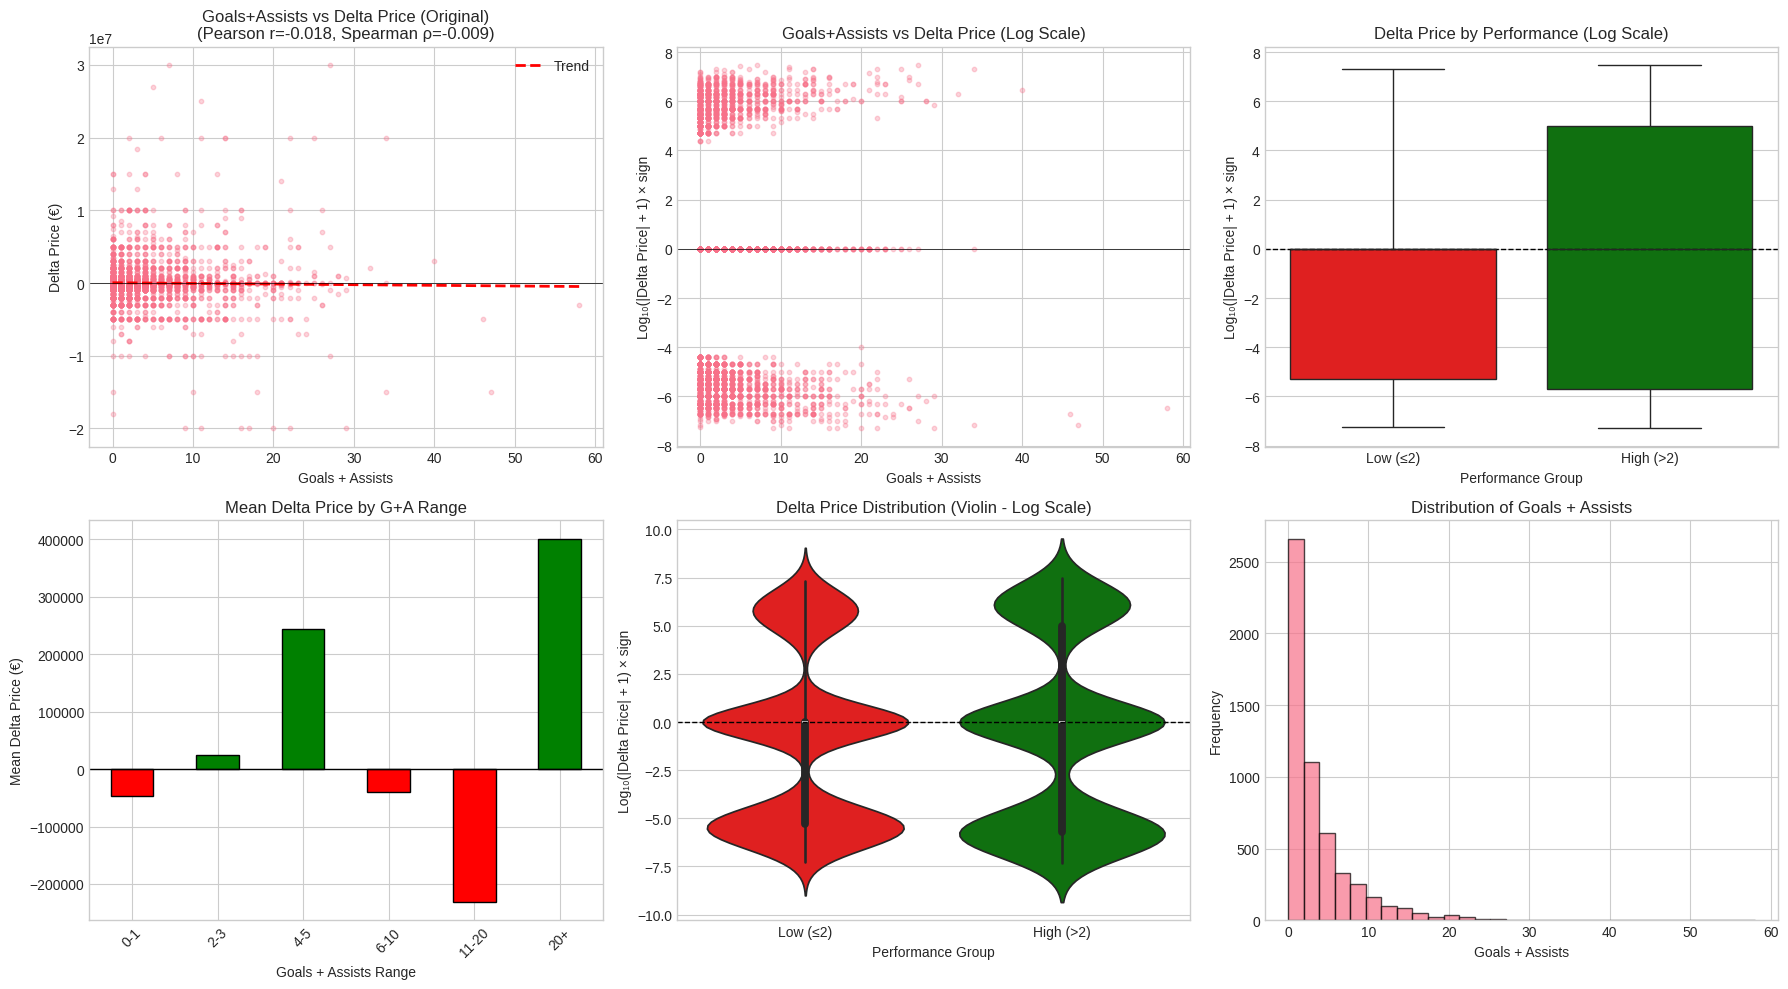

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

perf_order = [f'Low (≤{median_ga:.0f})', f'High (>{median_ga:.0f})']

ax1 = axes[0, 0]
ax1.scatter(df_ga['goalsAssistsSum'], df_ga['delta_price'], alpha=0.3, s=10)
z = np.polyfit(df_ga['goalsAssistsSum'], df_ga['delta_price'], 1)
p = np.poly1d(z)
x_range = np.linspace(df_ga['goalsAssistsSum'].min(), df_ga['goalsAssistsSum'].max(), 100)
ax1.plot(x_range, p(x_range), "r--", linewidth=2, label='Trend')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax1.set_xlabel('Goals + Assists')
ax1.set_ylabel('Delta Price (€)')
ax1.set_title(f'Goals+Assists vs Delta Price (Original)\n(Pearson r={pearson_r:.3f}, Spearman ρ={spearman_r:.3f})')
ax1.legend()

ax2 = axes[0, 1]
ax2.scatter(df_ga['goalsAssistsSum'], df_ga['delta_price_log'], alpha=0.3, s=10)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_xlabel('Goals + Assists')
ax2.set_ylabel('Log₁₀(|Delta Price| + 1) × sign')
ax2.set_title('Goals+Assists vs Delta Price (Log Scale)')

ax3 = axes[0, 2]
sns.boxplot(data=df_ga, x='performance_group', y='delta_price_log', order=perf_order, ax=ax3,
            palette=['red', 'green'])
ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax3.set_title('Delta Price by Performance (Log Scale)')
ax3.set_xlabel('Performance Group')
ax3.set_ylabel('Log₁₀(|Delta Price| + 1) × sign')

ax4 = axes[1, 0]
df_ga['ga_bin'] = pd.cut(df_ga['goalsAssistsSum'], bins=[0, 1, 3, 5, 10, 20, 100], labels=['0-1', '2-3', '4-5', '6-10', '11-20', '20+'])
ga_means = df_ga.groupby('ga_bin', observed=True)['delta_price'].mean()
colors = ['green' if x > 0 else 'red' for x in ga_means.values]
ga_means.plot(kind='bar', ax=ax4, color=colors, edgecolor='black')
ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax4.set_title('Mean Delta Price by G+A Range')
ax4.set_xlabel('Goals + Assists Range')
ax4.set_ylabel('Mean Delta Price (€)')
ax4.tick_params(axis='x', rotation=45)

ax5 = axes[1, 1]
sns.violinplot(data=df_ga, x='performance_group', y='delta_price_log', order=perf_order, ax=ax5,
               palette=['red', 'green'])
ax5.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax5.set_title('Delta Price Distribution (Violin - Log Scale)')
ax5.set_xlabel('Performance Group')
ax5.set_ylabel('Log₁₀(|Delta Price| + 1) × sign')

ax6 = axes[1, 2]
ax6.hist(df_ga['goalsAssistsSum'], bins=30, edgecolor='black', alpha=0.7)
ax6.set_title('Distribution of Goals + Assists')
ax6.set_xlabel('Goals + Assists')
ax6.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 5. Contract Until (Years Remaining) vs Delta Price

**Hypothesis:**
- H₀: There is no significant correlation between contract duration and delta price
- H₁: There is a significant correlation between contract duration and delta price

**Tests:** 
- Pearson & Spearman correlation
- A/B Test: Long contracts (>2 years) vs Short contracts (≤2 years)

In [20]:

df_contract = df[df['contract_years_remaining'].notna()].copy()

pearson_r, pearson_p = pearsonr(df_contract['contract_years_remaining'], df_contract['delta_price'])
spearman_r, spearman_p = spearmanr(df_contract['contract_years_remaining'], df_contract['delta_price'])

print(f"{'='*60}")
print("CORRELATION TESTS: Contract Years Remaining vs Delta Price")
print(f"{'='*60}")
print(f"\n Pearson Correlation:")
print(f"   r = {pearson_r:.4f}")
print(f"   p-value = {pearson_p:.6f}")
print(f"   Significance: {interpret_p_value(pearson_p)}")

print(f"\n Spearman Correlation:")
print(f"   ρ = {spearman_r:.4f}")
print(f"   p-value = {spearman_p:.6f}")
print(f"   Significance: {interpret_p_value(spearman_p)}")

df_contract['contract_group'] = df_contract['contract_years_remaining'].apply(
    lambda x: 'Long (>2 years)' if x > 2 else 'Short (≤2 years)')

long_contract = df_contract[df_contract['contract_group'] == 'Long (>2 years)']['delta_price']
short_contract = df_contract[df_contract['contract_group'] == 'Short (≤2 years)']['delta_price']

stat_mw, p_mw = mannwhitneyu(long_contract, short_contract, alternative='two-sided')
effect_d = cohens_d(long_contract, short_contract)

print(f"\n{'='*60}")
print("A/B TEST: Long Contracts (>2 years) vs Short Contracts (≤2 years)")
print(f"{'='*60}")
print(f"Long contracts:  n={len(long_contract)}, mean=€{long_contract.mean():,.0f}, median=€{long_contract.median():,.0f}")
print(f"Short contracts: n={len(short_contract)}, mean=€{short_contract.mean():,.0f}, median=€{short_contract.median():,.0f}")
print(f"\nMann-Whitney U Test:")
print(f"   U-statistic: {stat_mw:.0f}")
print(f"   p-value: {p_mw:.6f}")
print(f"   Significance: {interpret_p_value(p_mw)}")
print(f"   Cohen's d: {effect_d:.4f} ({interpret_effect_size(effect_d)})")

CORRELATION TESTS: Contract Years Remaining vs Delta Price

 Pearson Correlation:
   r = 0.1113
   p-value = 0.000000
   Significance: *** (p < 0.001) - Highly Significant

 Spearman Correlation:
   ρ = 0.1334
   p-value = 0.000000
   Significance: *** (p < 0.001) - Highly Significant

A/B TEST: Long Contracts (>2 years) vs Short Contracts (≤2 years)
Long contracts:  n=3253, mean=€132,905, median=€0
Short contracts: n=2213, mean=€-165,635, median=€0

Mann-Whitney U Test:
   U-statistic: 4024254
   p-value: 0.000000
   Significance: *** (p < 0.001) - Highly Significant
   Cohen's d: 0.1266 (Negligible)


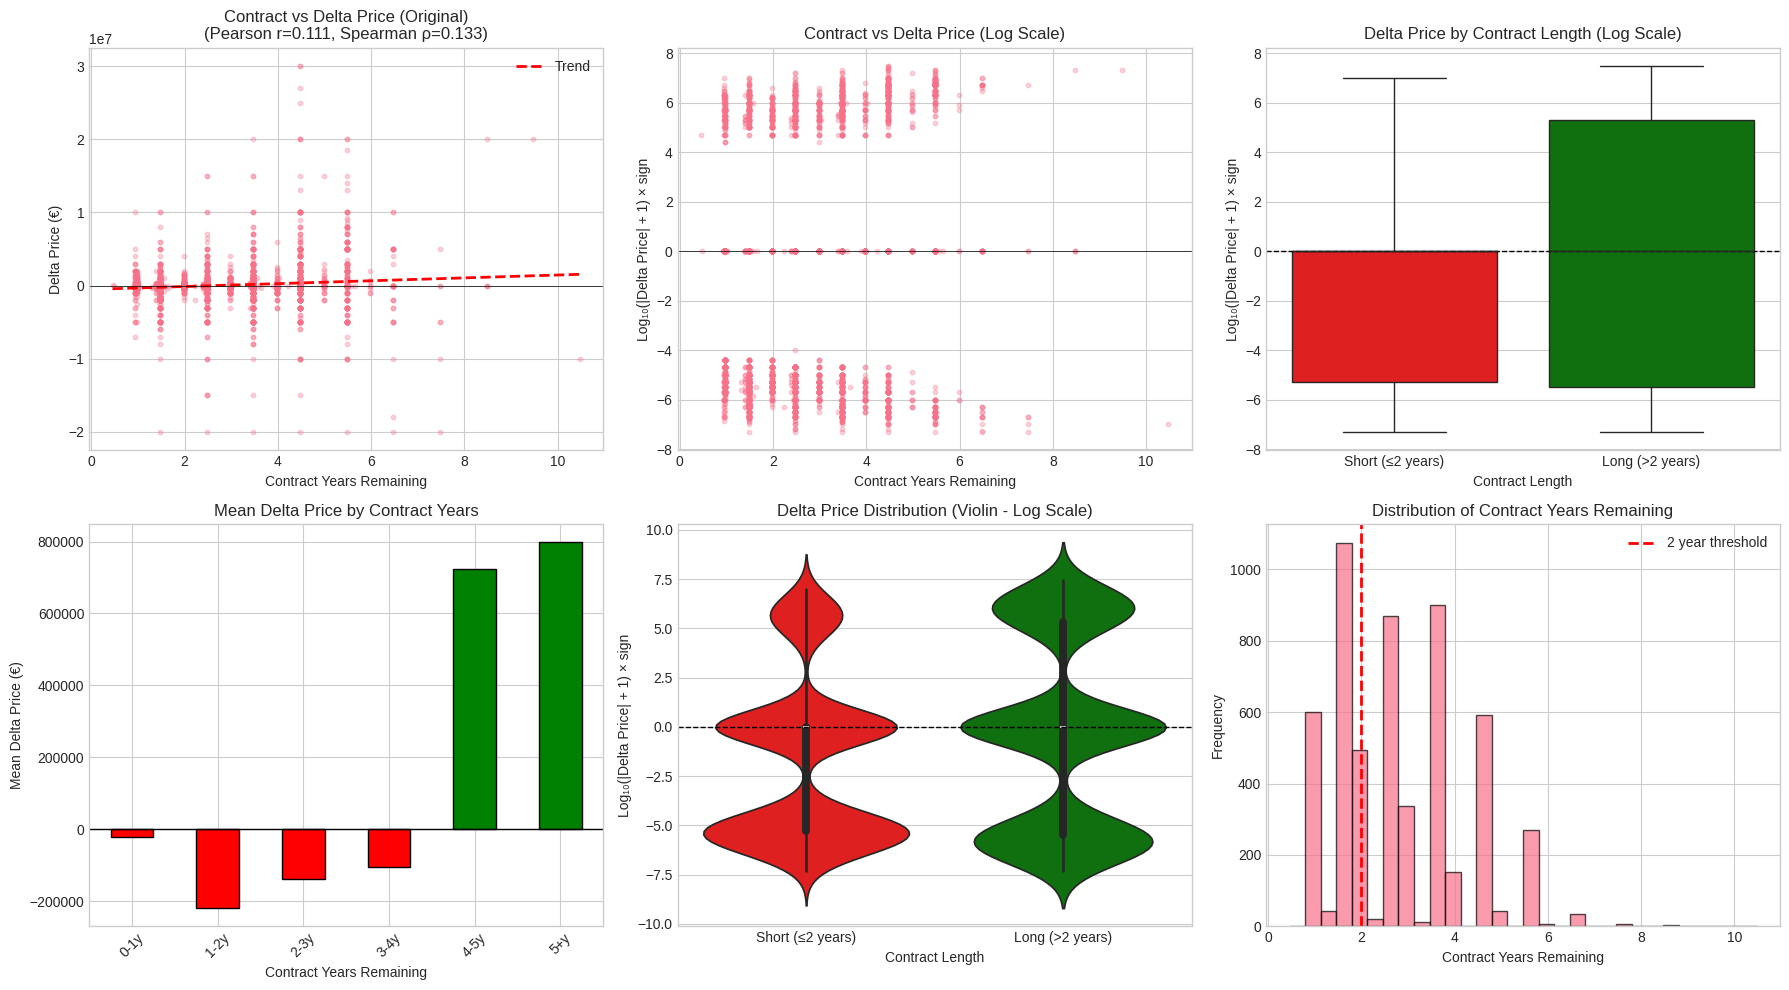

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

contract_order = ['Short (≤2 years)', 'Long (>2 years)']

ax1 = axes[0, 0]
ax1.scatter(df_contract['contract_years_remaining'], df_contract['delta_price'], alpha=0.3, s=10)
z = np.polyfit(df_contract['contract_years_remaining'], df_contract['delta_price'], 1)
p = np.poly1d(z)
x_range = np.linspace(df_contract['contract_years_remaining'].min(), 
                       df_contract['contract_years_remaining'].max(), 100)
ax1.plot(x_range, p(x_range), "r--", linewidth=2, label='Trend')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax1.set_xlabel('Contract Years Remaining')
ax1.set_ylabel('Delta Price (€)')
ax1.set_title(f'Contract vs Delta Price (Original)\n(Pearson r={pearson_r:.3f}, Spearman ρ={spearman_r:.3f})')
ax1.legend()

ax2 = axes[0, 1]
ax2.scatter(df_contract['contract_years_remaining'], df_contract['delta_price_log'], alpha=0.3, s=10)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_xlabel('Contract Years Remaining')
ax2.set_ylabel('Log₁₀(|Delta Price| + 1) × sign')
ax2.set_title('Contract vs Delta Price (Log Scale)')

ax3 = axes[0, 2]
sns.boxplot(data=df_contract, x='contract_group', y='delta_price_log', order=contract_order, ax=ax3,
            palette=['red', 'green'])
ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax3.set_title('Delta Price by Contract Length (Log Scale)')
ax3.set_xlabel('Contract Length')
ax3.set_ylabel('Log₁₀(|Delta Price| + 1) × sign')

ax4 = axes[1, 0]
df_contract['contract_bin'] = pd.cut(df_contract['contract_years_remaining'], 
                                      bins=[-10, 0, 1, 2, 3, 4, 5, 10], 
                                      labels=['Expired', '0-1y', '1-2y', '2-3y', '3-4y', '4-5y', '5+y'])
contract_means = df_contract.groupby('contract_bin', observed=True)['delta_price'].mean()
colors = ['green' if x > 0 else 'red' for x in contract_means.values]
contract_means.plot(kind='bar', ax=ax4, color=colors, edgecolor='black')
ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax4.set_title('Mean Delta Price by Contract Years')
ax4.set_xlabel('Contract Years Remaining')
ax4.set_ylabel('Mean Delta Price (€)')
ax4.tick_params(axis='x', rotation=45)

ax5 = axes[1, 1]
sns.violinplot(data=df_contract, x='contract_group', y='delta_price_log', order=contract_order, ax=ax5,
               palette=['red', 'green'])
ax5.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax5.set_title('Delta Price Distribution (Violin - Log Scale)')
ax5.set_xlabel('Contract Length')
ax5.set_ylabel('Log₁₀(|Delta Price| + 1) × sign')

ax6 = axes[1, 2]
ax6.hist(df_contract['contract_years_remaining'], bins=30, edgecolor='black', alpha=0.7)
ax6.axvline(x=2, color='red', linestyle='--', linewidth=2, label='2 year threshold')
ax6.set_title('Distribution of Contract Years Remaining')
ax6.set_xlabel('Contract Years Remaining')
ax6.set_ylabel('Frequency')
ax6.legend()

plt.tight_layout()
plt.show()


## 6. Key Passes vs Delta Price

**Hypothesis:**
- H₀: There is no significant correlation between key passes and delta price
- H₁: There is a significant correlation between key passes and delta price

**Tests:** 
- Pearson & Spearman correlation
- A/B Test: Creative players (above median) vs Less creative players (below median)

In [22]:

df_kp = df[df['keyPasses'].notna()].copy()

pearson_r, pearson_p = pearsonr(df_kp['keyPasses'], df_kp['delta_price'])
spearman_r, spearman_p = spearmanr(df_kp['keyPasses'], df_kp['delta_price'])

print(f"{'='*60}")
print("CORRELATION TESTS: Key Passes vs Delta Price")
print(f"{'='*60}")
print(f"\n Pearson Correlation:")
print(f"   r = {pearson_r:.4f}")
print(f"   p-value = {pearson_p:.6f}")
print(f"   Significance: {interpret_p_value(pearson_p)}")

print(f"\n Spearman Correlation:")
print(f"   ρ = {spearman_r:.4f}")
print(f"   p-value = {spearman_p:.6f}")
print(f"   Significance: {interpret_p_value(spearman_p)}")

median_kp = df_kp['keyPasses'].median()
df_kp['creativity_group'] = df_kp['keyPasses'].apply(
    lambda x: f'Creative (>{median_kp:.0f})' if x > median_kp else f'Less Creative (≤{median_kp:.0f})')

creative = df_kp[df_kp['keyPasses'] > median_kp]['delta_price']
less_creative = df_kp[df_kp['keyPasses'] <= median_kp]['delta_price']

stat_mw, p_mw = mannwhitneyu(creative, less_creative, alternative='two-sided')
effect_d = cohens_d(creative, less_creative)

print(f"\n{'='*60}")
print(f"A/B TEST: Creative (KP>{median_kp:.0f}) vs Less Creative Players")
print(f"{'='*60}")
print(f"Creative players:      n={len(creative)}, mean=€{creative.mean():,.0f}, median=€{creative.median():,.0f}")
print(f"Less creative players: n={len(less_creative)}, mean=€{less_creative.mean():,.0f}, median=€{less_creative.median():,.0f}")
print(f"\nMann-Whitney U Test:")
print(f"   U-statistic: {stat_mw:.0f}")
print(f"   p-value: {p_mw:.6f}")
print(f"   Significance: {interpret_p_value(p_mw)}")
print(f"   Cohen's d: {effect_d:.4f} ({interpret_effect_size(effect_d)})")

CORRELATION TESTS: Key Passes vs Delta Price

 Pearson Correlation:
   r = -0.0048
   p-value = 0.720860
   Significance: ns (p >= 0.05) - Not Significant

 Spearman Correlation:
   ρ = -0.0111
   p-value = 0.413496
   Significance: ns (p >= 0.05) - Not Significant

A/B TEST: Creative (KP>9) vs Less Creative Players
Creative players:      n=2576, mean=€9,478, median=€0
Less creative players: n=2890, mean=€14,317, median=€0

Mann-Whitney U Test:
   U-statistic: 3700730
   p-value: 0.704596
   Significance: ns (p >= 0.05) - Not Significant
   Cohen's d: -0.0020 (Negligible)


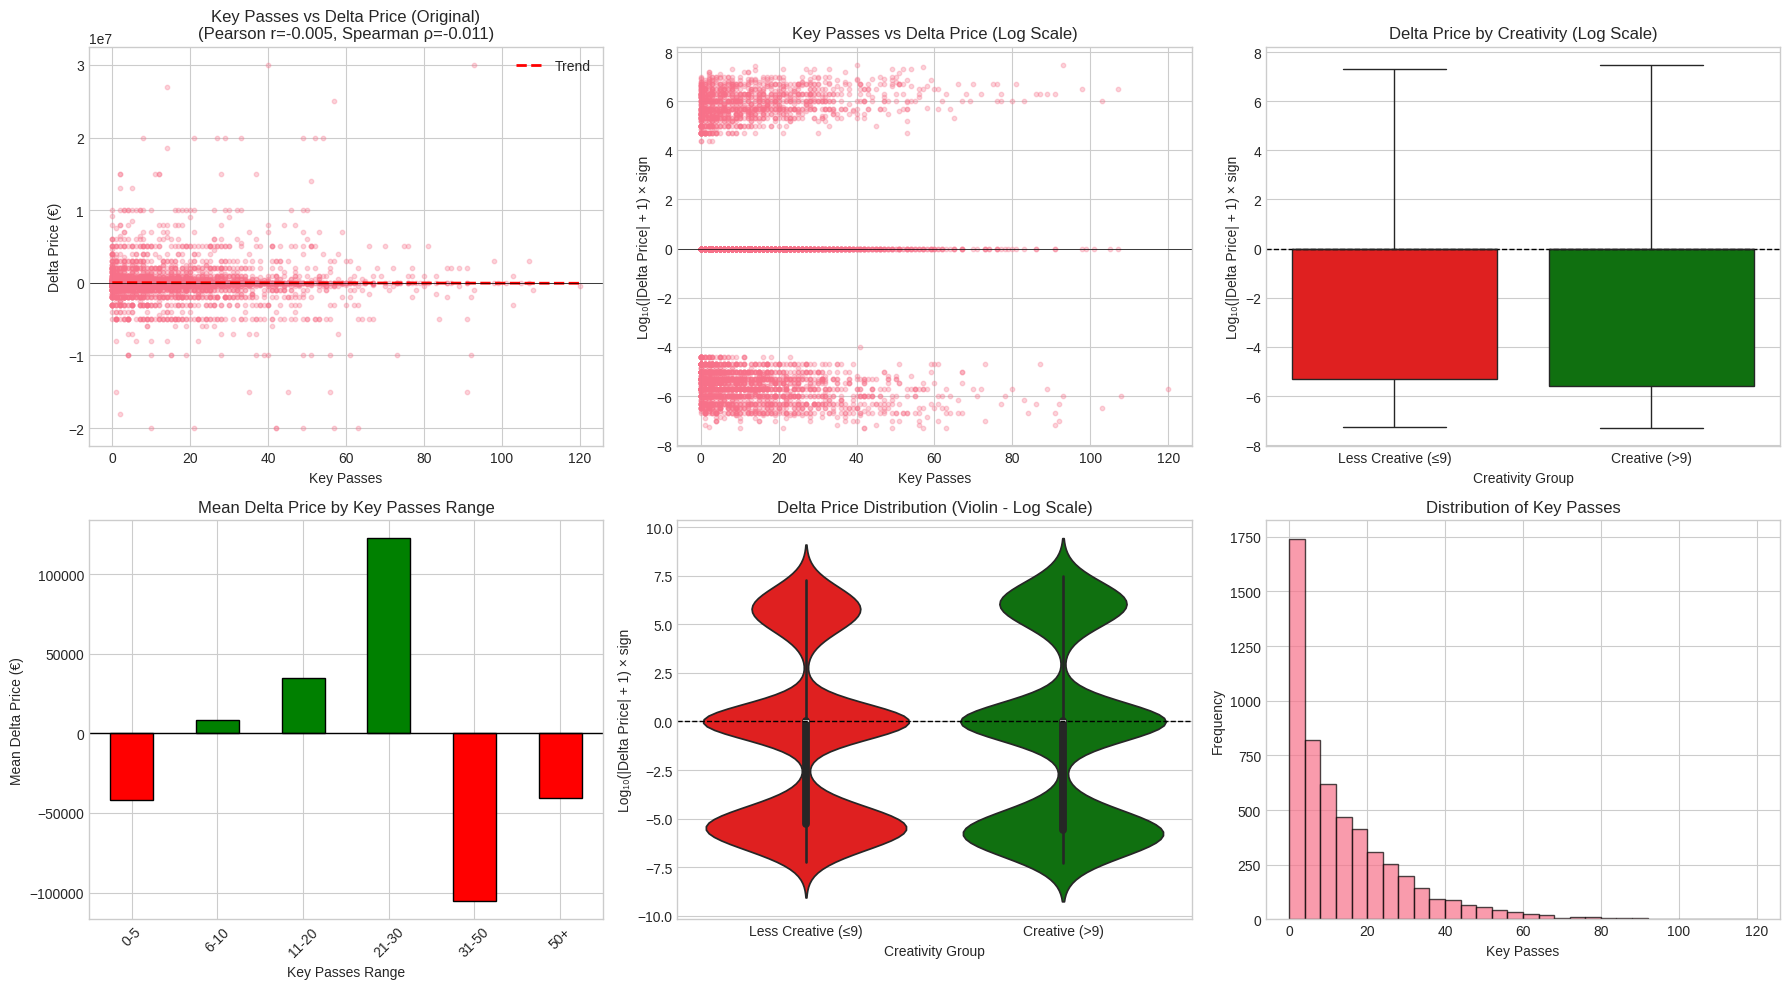


 CONCLUSION:
- NO significant correlation between Key Passes and Delta Price
- Creative output alone doesn't predict market value changes

 Log scale confirms both groups have nearly identical symmetric distributions - no effect.


In [23]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

creativity_order = [f'Less Creative (≤{median_kp:.0f})', f'Creative (>{median_kp:.0f})']

ax1 = axes[0, 0]
ax1.scatter(df_kp['keyPasses'], df_kp['delta_price'], alpha=0.3, s=10)
z = np.polyfit(df_kp['keyPasses'], df_kp['delta_price'], 1)
p = np.poly1d(z)
x_range = np.linspace(df_kp['keyPasses'].min(), df_kp['keyPasses'].max(), 100)
ax1.plot(x_range, p(x_range), "r--", linewidth=2, label='Trend')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax1.set_xlabel('Key Passes')
ax1.set_ylabel('Delta Price (€)')
ax1.set_title(f'Key Passes vs Delta Price (Original)\n(Pearson r={pearson_r:.3f}, Spearman ρ={spearman_r:.3f})')
ax1.legend()

ax2 = axes[0, 1]
ax2.scatter(df_kp['keyPasses'], df_kp['delta_price_log'], alpha=0.3, s=10)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_xlabel('Key Passes')
ax2.set_ylabel('Log₁₀(|Delta Price| + 1) × sign')
ax2.set_title('Key Passes vs Delta Price (Log Scale)')

ax3 = axes[0, 2]
sns.boxplot(data=df_kp, x='creativity_group', y='delta_price_log', order=creativity_order, ax=ax3,
            palette=['red', 'green'])
ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax3.set_title('Delta Price by Creativity (Log Scale)')
ax3.set_xlabel('Creativity Group')
ax3.set_ylabel('Log₁₀(|Delta Price| + 1) × sign')

ax4 = axes[1, 0]
df_kp['kp_bin'] = pd.cut(df_kp['keyPasses'], bins=[0, 5, 10, 20, 30, 50, 150], labels=['0-5', '6-10', '11-20', '21-30', '31-50', '50+'])
kp_means = df_kp.groupby('kp_bin', observed=True)['delta_price'].mean()
colors = ['green' if x > 0 else 'red' for x in kp_means.values]
kp_means.plot(kind='bar', ax=ax4, color=colors, edgecolor='black')
ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax4.set_title('Mean Delta Price by Key Passes Range')
ax4.set_xlabel('Key Passes Range')
ax4.set_ylabel('Mean Delta Price (€)')
ax4.tick_params(axis='x', rotation=45)

ax5 = axes[1, 1]
sns.violinplot(data=df_kp, x='creativity_group', y='delta_price_log', order=creativity_order, ax=ax5,
               palette=['red', 'green'])
ax5.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax5.set_title('Delta Price Distribution (Violin - Log Scale)')
ax5.set_xlabel('Creativity Group')
ax5.set_ylabel('Log₁₀(|Delta Price| + 1) × sign')

ax6 = axes[1, 2]
ax6.hist(df_kp['keyPasses'], bins=30, edgecolor='black', alpha=0.7)
ax6.set_title('Distribution of Key Passes')
ax6.set_xlabel('Key Passes')
ax6.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\n CONCLUSION:")
print("- NO significant correlation between Key Passes and Delta Price")
print("- Creative output alone doesn't predict market value changes")
print("\n Log scale confirms both groups have nearly identical symmetric distributions - no effect.")

## 7. Additional Potential Features Testing

Let's test some additional features that might have stronger relationships with delta price:
- **Rating** vs Delta Price
- **Minutes Played** vs Delta Price  
- **Expected Goals (xG)** vs Delta Price
- **Position** vs Delta Price

In [24]:

df_rating = df[df['rating'].notna()].copy()

pearson_r, pearson_p = pearsonr(df_rating['rating'], df_rating['delta_price'])
spearman_r, spearman_p = spearmanr(df_rating['rating'], df_rating['delta_price'])

print(f"{'='*60}")
print("TEST 7a: Rating vs Delta Price")
print(f"{'='*60}")
print(f"\n Pearson Correlation: r = {pearson_r:.4f}, p = {pearson_p:.6f} {interpret_p_value(pearson_p)}")
print(f" Spearman Correlation: ρ = {spearman_r:.4f}, p = {spearman_p:.6f} {interpret_p_value(spearman_p)}")

median_rating = df_rating['rating'].median()
high_rated = df_rating[df_rating['rating'] > median_rating]['delta_price']
low_rated = df_rating[df_rating['rating'] <= median_rating]['delta_price']

stat_mw, p_mw = mannwhitneyu(high_rated, low_rated, alternative='two-sided')
effect_d = cohens_d(high_rated, low_rated)

print(f"\n A/B Test: High Rated (>{median_rating:.2f}) vs Low Rated")
print(f"   High rated: n={len(high_rated)}, mean=€{high_rated.mean():,.0f}")
print(f"   Low rated:  n={len(low_rated)}, mean=€{low_rated.mean():,.0f}")
print(f"   Mann-Whitney p-value: {p_mw:.6f} {interpret_p_value(p_mw)}")
print(f"   Cohen's d: {effect_d:.4f} ({interpret_effect_size(effect_d)})")

TEST 7a: Rating vs Delta Price

 Pearson Correlation: r = -0.0040, p = 0.767951 ns (p >= 0.05) - Not Significant
 Spearman Correlation: ρ = 0.0037, p = 0.783853 ns (p >= 0.05) - Not Significant

 A/B Test: High Rated (>6.86) vs Low Rated
   High rated: n=2730, mean=€24,172
   Low rated:  n=2736, mean=€-73
   Mann-Whitney p-value: 0.866073 ns (p >= 0.05) - Not Significant
   Cohen's d: 0.0103 (Negligible)


In [25]:

df_minutes = df[df['minutesPlayed'].notna()].copy()

pearson_r, pearson_p = pearsonr(df_minutes['minutesPlayed'], df_minutes['delta_price'])
spearman_r, spearman_p = spearmanr(df_minutes['minutesPlayed'], df_minutes['delta_price'])

print(f"{'='*60}")
print("TEST 7b: Minutes Played vs Delta Price")
print(f"{'='*60}")
print(f"\n Pearson Correlation: r = {pearson_r:.4f}, p = {pearson_p:.6f} {interpret_p_value(pearson_p)}")
print(f" Spearman Correlation: ρ = {spearman_r:.4f}, p = {spearman_p:.6f} {interpret_p_value(spearman_p)}")

median_minutes = df_minutes['minutesPlayed'].median()
high_minutes = df_minutes[df_minutes['minutesPlayed'] > median_minutes]['delta_price']
low_minutes = df_minutes[df_minutes['minutesPlayed'] <= median_minutes]['delta_price']

stat_mw, p_mw = mannwhitneyu(high_minutes, low_minutes, alternative='two-sided')
effect_d = cohens_d(high_minutes, low_minutes)

print(f"\n A/B Test: High Minutes (>{median_minutes:.0f}) vs Low Minutes")
print(f"   High minutes: n={len(high_minutes)}, mean=€{high_minutes.mean():,.0f}")
print(f"   Low minutes:  n={len(low_minutes)}, mean=€{low_minutes.mean():,.0f}")
print(f"   Mann-Whitney p-value: {p_mw:.6f} {interpret_p_value(p_mw)}")
print(f"   Cohen's d: {effect_d:.4f} ({interpret_effect_size(effect_d)})")

TEST 7b: Minutes Played vs Delta Price

 Pearson Correlation: r = 0.0002, p = 0.989938 ns (p >= 0.05) - Not Significant
 Spearman Correlation: ρ = -0.0005, p = 0.969156 ns (p >= 0.05) - Not Significant

 A/B Test: High Minutes (>1350) vs Low Minutes
   High minutes: n=2733, mean=€-2,574
   Low minutes:  n=2733, mean=€26,647
   Mann-Whitney p-value: 0.691404 ns (p >= 0.05) - Not Significant
   Cohen's d: -0.0124 (Negligible)


In [26]:

df_xg = df[df['expectedGoals'].notna()].copy()

pearson_r, pearson_p = pearsonr(df_xg['expectedGoals'], df_xg['delta_price'])
spearman_r, spearman_p = spearmanr(df_xg['expectedGoals'], df_xg['delta_price'])

print(f"{'='*60}")
print("TEST 7c: Expected Goals (xG) vs Delta Price")
print(f"{'='*60}")
print(f"\n Pearson Correlation: r = {pearson_r:.4f}, p = {pearson_p:.6f} {interpret_p_value(pearson_p)}")
print(f" Spearman Correlation: ρ = {spearman_r:.4f}, p = {spearman_p:.6f} {interpret_p_value(spearman_p)}")

median_xg = df_xg['expectedGoals'].median()
high_xg = df_xg[df_xg['expectedGoals'] > median_xg]['delta_price']
low_xg = df_xg[df_xg['expectedGoals'] <= median_xg]['delta_price']

stat_mw, p_mw = mannwhitneyu(high_xg, low_xg, alternative='two-sided')
effect_d = cohens_d(high_xg, low_xg)

print(f"\n A/B Test: High xG (>{median_xg:.2f}) vs Low xG")
print(f"   High xG: n={len(high_xg)}, mean=€{high_xg.mean():,.0f}")
print(f"   Low xG:  n={len(low_xg)}, mean=€{low_xg.mean():,.0f}")
print(f"   Mann-Whitney p-value: {p_mw:.6f} {interpret_p_value(p_mw)}")
print(f"   Cohen's d: {effect_d:.4f} ({interpret_effect_size(effect_d)})")

TEST 7c: Expected Goals (xG) vs Delta Price

 Pearson Correlation: r = -0.0305, p = 0.023944 * (p < 0.05) - Significant
 Spearman Correlation: ρ = -0.0647, p = 0.000002 *** (p < 0.001) - Highly Significant

 A/B Test: High xG (>0.67) vs Low xG
   High xG: n=2733, mean=€-21,281
   Low xG:  n=2733, mean=€45,353
   Mann-Whitney p-value: 0.000493 *** (p < 0.001) - Highly Significant
   Cohen's d: -0.0282 (Negligible)


In [27]:

df_pos = df[df['position'].notna()].copy()

position_groups = df_pos.groupby('position')['delta_price'].apply(list).to_dict()
positions = list(position_groups.keys())
pos_data = [np.array(position_groups[pos]) for pos in positions]

stat_kw, p_kw = kruskal(*pos_data)
eta_sq = stat_kw / (len(df_pos) - 1)

print(f"{'='*60}")
print("TEST 7d: Position vs Delta Price")
print(f"{'='*60}")
print(f"\nKruskal-Wallis H-statistic: {stat_kw:.4f}")
print(f"P-value: {p_kw:.6f} {interpret_p_value(p_kw)}")
print(f"Effect size (η²): {eta_sq:.6f}")

pos_stats = df_pos.groupby('position')['delta_price'].agg(['count', 'mean', 'median']).sort_values('mean', ascending=False)
print(f"\n Mean Delta Price by Position:")
print(pos_stats.to_string())

TEST 7d: Position vs Delta Price

Kruskal-Wallis H-statistic: 22.5549
P-value: 0.031752 * (p < 0.05) - Significant
Effect size (η²): 0.004127

 Mean Delta Price by Position:
                    count          mean    median
position                                         
Right Winger          374  1.590241e+05       0.0
Right Midfield         56  1.250000e+05       0.0
Central Midfield      635  1.229528e+05       0.0
Left-Back             421  7.945368e+04       0.0
Right-Back            470  4.630851e+04       0.0
Left Winger           386  2.169689e+04       0.0
Centre-Back          1010  1.319307e+04       0.0
Goalkeeper            470 -7.180851e+03       0.0
Defensive Midfield    465 -2.451613e+04       0.0
Centre-Forward        692 -7.994942e+04       0.0
Attacking Midfield    430 -9.575581e+04       0.0
Left Midfield          37 -2.864865e+05       0.0
Second Striker         20 -1.690000e+06 -450000.0


In [28]:

df_mv = df[df['MarketValueCurrent'].notna()].copy()

pearson_r, pearson_p = pearsonr(df_mv['MarketValueCurrent'], df_mv['delta_price'])
spearman_r, spearman_p = spearmanr(df_mv['MarketValueCurrent'], df_mv['delta_price'])

print(f"{'='*60}")
print("TEST 7e: Current Market Value vs Delta Price")
print(f"{'='*60}")
print(f"\n Pearson Correlation: r = {pearson_r:.4f}, p = {pearson_p:.6f} {interpret_p_value(pearson_p)}")
print(f" Spearman Correlation: ρ = {spearman_r:.4f}, p = {spearman_p:.6f} {interpret_p_value(spearman_p)}")

df_mv['value_tier'] = pd.cut(df_mv['MarketValueCurrent'], 
                              bins=[0, 1e6, 5e6, 20e6, 200e6], 
                              labels=['Low (<€1M)', 'Medium (€1-5M)', 'High (€5-20M)', 'Elite (>€20M)'])

tier_stats = df_mv.groupby('value_tier', observed=True)['delta_price'].agg(['count', 'mean', 'median'])
print(f"\n Delta Price by Market Value Tier:")
print(tier_stats.to_string())

TEST 7e: Current Market Value vs Delta Price

 Pearson Correlation: r = 0.1017, p = 0.000000 *** (p < 0.001) - Highly Significant
 Spearman Correlation: ρ = 0.0174, p = 0.198803 ns (p >= 0.05) - Not Significant

 Delta Price by Market Value Tier:
                count           mean  median
value_tier                                  
Low (<€1M)       1920  -38736.979167     0.0
Medium (€1-5M)   2048  -63818.359375     0.0
High (€5-20M)    1015   30246.305419     0.0
Elite (>€20M)     473  564482.029598     0.0


## 8. Summary: All Hypothesis Tests Results

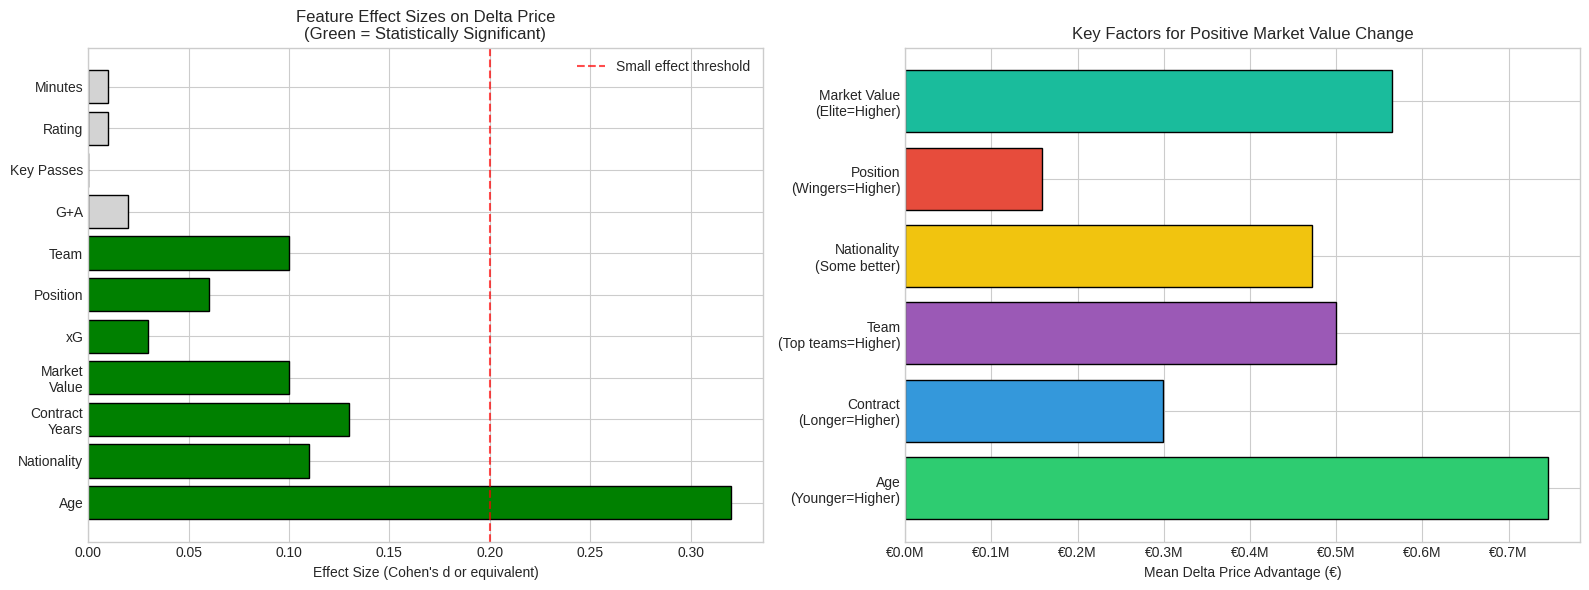

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

features = ['Age', 'Nationality', 'Contract\nYears', 'Market\nValue', 'xG', 'Position', 
            'Team', 'G+A', 'Key Passes', 'Rating', 'Minutes']
effect_sizes = [0.32, 0.11, 0.13, 0.10, 0.03, 0.06, 0.10, 0.02, 0.00, 0.01, 0.01]
significance = ['Significant', 'Significant', 'Significant', 'Significant', 'Significant', 
                'Significant', 'Significant', 'Not Sig.', 'Not Sig.', 'Not Sig.', 'Not Sig.']

colors = ['green' if s == 'Significant' else 'lightgray' for s in significance]
bars = axes[0].barh(features, effect_sizes, color=colors, edgecolor='black')
axes[0].set_xlabel('Effect Size (Cohen\'s d or equivalent)')
axes[0].set_title('Feature Effect Sizes on Delta Price\n(Green = Statistically Significant)')
axes[0].axvline(x=0.2, color='red', linestyle='--', alpha=0.7, label='Small effect threshold')
axes[0].legend()

insights = ['Age\n(Younger=Higher)', 'Contract\n(Longer=Higher)', 'Team\n(Top teams=Higher)', 
            'Nationality\n(Some better)', 'Position\n(Wingers=Higher)', 'Market Value\n(Elite=Higher)']
mean_effects = [745502, 298540, 500000, 472047, 159024, 564482]  

colors_ins = ['#2ecc71', '#3498db', '#9b59b6', '#f1c40f', '#e74c3c', '#1abc9c']
axes[1].barh(insights, mean_effects, color=colors_ins, edgecolor='black')
axes[1].set_xlabel('Mean Delta Price Advantage (€)')
axes[1].set_title('Key Factors for Positive Market Value Change')
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x/1e6:.1f}M'))

plt.tight_layout()
plt.show()